In [3]:
import awkward as ak
import uproot
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import os, sys

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

from boostedhiggs.btag import BTagCorrector
from boostedhiggs.corrections import (
    corrected_msoftdrop,
    n2ddt_shift,
    add_pileup_weight,
    add_HiggsEW_kFactors,
    add_VJets_kFactors,
    add_jetTriggerSF,
    add_muonSFs,
    jet_factory,
    fatjet_factory,
    add_jec_variables,
    met_factory,
    lumiMasks,

    # Jennet adds theory variations                                                                                                
    add_ps_weight,
    add_scalevar_7pt,
    add_scalevar_3pt,
    add_pdf_weight,
)



/opt/conda/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [7]:
singlet_path='root://cmseos.fnal.gov:1094//store/user/lpcpfnano/cmantill/v2_3/2017/SingleTop/ST_tW_top_5f_NoFullyHadronicDecays_TuneCP5_13TeV_PDFWeights-powheg-pythia8/ST_tW_top_5f_NoFullyHadronicDecays/230217_201407/0000/nano_mc2017_1-7.root'
ttbar_path='root://cmseos.fnal.gov:1094//store/group/lpcpfnano/jdickins/v2_3/2017/TTbarBoosted/TT_Mtt-700to1000_TuneCP5_13TeV-powheg-pythia8/TT_MTT700To1000/220809_162200/0000/nano_mc2017_2-80.root'
qcd_path='root://cmseos.fnal.gov:1094//store/user/lpcpfnano/cmantill/v2_3/2017/QCD/QCD_HT1500to2000_TuneCP5_PSWeights_13TeV-madgraph-pythia8/QCD_HT1500to2000/220808_164504/0000/nano_mc2017_101.root'
ZH_path='root://cmseos.fnal.gov:1094//store/user/lpcpfnano/cmantill/v2_3/2017/HToBB/ZH_HToBB_ZToQQ_M-125_TuneCP5_13TeV-powheg-pythia8/ZH_HToBB_ZToQQ/230217_201213/0000/nano_mc2017_61.root'
WH_path='root://cmseos.fnal.gov:1094//store/user/lpcpfnano/cmantill/v2_3/2017/HToBB/WplusH_HToBB_WToQQ_M-125_TuneCP5_13TeV-powheg-pythia8/WplusH_HToBB_WToQQ/230217_201113/0000/nano_mc2017_29.root'

In [5]:
!export XRD_RUNFORKHANDLER=1

In [8]:
singlet_events =  NanoEventsFactory.from_root(singlet_path, schemaclass=NanoAODSchema).events()
ttbar_events = NanoEventsFactory.from_root(ttbar_path, schemaclass=NanoAODSchema).events()
qcd_events = NanoEventsFactory.from_root(qcd_path, schemaclass=NanoAODSchema).events()
ZH_events = NanoEventsFactory.from_root(ZH_path, schemaclass=NanoAODSchema).events()
WH_events = NanoEventsFactory.from_root(WH_path, schemaclass=NanoAODSchema).events()

/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1975 branches) at 0x7fb3c75fc280>, taking first instance
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1975 branches) at 0x7fb3c75fc280>, taking first instance
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1975 branches) at 0x7fb3c75fc280>, taking first instance
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Events' (1975 branches) at 0x7fb3c75fc280>, taking first instance
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/mapping/upr

In [9]:
def select_leading_jets(events):

    fatjets = events.FatJet
    fatjets['msdcorr'] = corrected_msoftdrop(fatjets)
    fatjets['qcdrho'] = 2 * np.log(fatjets.msdcorr / fatjets.pt)
    fatjets['n2ddt'] = fatjets.n2b1 - n2ddt_shift(fatjets, year='2017')

    candidatejets = fatjets[(fatjets.pt > 200)
                           & (abs(fatjets.eta) < 2.5)
                           & fatjets.isTight
                          ]
    
    leadingjets = candidatejets[:, 0:2]

    pnet_bvc = leadingjets.particleNetMD_Xbb / (leadingjets.particleNetMD_Xcc + leadingjets.particleNetMD_Xbb)
    
    #Higher b score for the Higgs candidate (more b like)                                                                                                                           
    indices = ak.argsort(pnet_bvc, axis=1, ascending = False) 

    # candidate jet is more b-like (higher BvC score)                                                                                                           
    candidatejet = ak.firsts(leadingjets[indices[:, 0:1]])
    
    # second jet is more charm-like (larger BvC score)                                                                                                           
    secondjet = ak.firsts(leadingjets[indices[:, 1:2]])

    n2_cut = (candidatejet.n2ddt < 0.) & (secondjet.n2ddt < 0.)
    jet1kin = (abs(candidatejet.eta) < 2.5) & (candidatejet.pt >= 450)
    jet2kin = (secondjet.pt >= 200) & (abs(secondjet.eta) < 2.5) & (secondjet.msdcorr <= 110) & (secondjet.msdcorr >= 68)
    jetacceptance = (candidatejet.msdcorr >= 40.) & (candidatejet.pt < 1200)  & (candidatejet.msdcorr < 201.) & (secondjet.msdcorr >= 40.) & (secondjet.pt < 1200)& (secondjet.msdcorr < 201.)

    selection = n2_cut & jet1kin & jet2kin & jetacceptance

    return candidatejet[selection], secondjet[selection]


def count_ak4_jets_selection(events):

    fatjets = events.FatJet
    fatjets['msdcorr'] = corrected_msoftdrop(fatjets)
    fatjets['qcdrho'] = 2 * np.log(fatjets.msdcorr / fatjets.pt)
    fatjets['n2ddt'] = fatjets.n2b1 - n2ddt_shift(fatjets, year='2017')

    candidatejets = fatjets[(fatjets.pt > 200)
                           & (abs(fatjets.eta) < 2.5)
                           & fatjets.isTight
                          ]
    
    leadingjets = candidatejets[:, 0:2]

    pnet_bvc = leadingjets.particleNetMD_Xbb / (leadingjets.particleNetMD_Xcc + leadingjets.particleNetMD_Xbb)
    
    #Higher b score for the Higgs candidate (more b like)                                                                                                                           
    indices = ak.argsort(pnet_bvc, axis=1, ascending = False) 

    # candidate jet is more b-like (higher BvC score)                                                                                                           
    candidatejet = ak.firsts(leadingjets[indices[:, 0:1]])
    
    # second jet is more charm-like (larger BvC score)                                                                                                           
    secondjet = ak.firsts(leadingjets[indices[:, 1:2]])

    n2_cut = (candidatejet.n2ddt < 0.) & (secondjet.n2ddt < 0.)
    jet1kin = (abs(candidatejet.eta) < 2.5) & (candidatejet.pt >= 450)
    jet2kin = (secondjet.pt >= 200) & (abs(secondjet.eta) < 2.5) & (secondjet.msdcorr <= 110) & (secondjet.msdcorr >= 68)
    jetacceptance = (candidatejet.msdcorr >= 40.) & (candidatejet.pt < 1200)  & (candidatejet.msdcorr < 201.) & (secondjet.msdcorr >= 40.) & (secondjet.pt < 1200)& (secondjet.msdcorr < 201.)

    selection = n2_cut & jet1kin & jet2kin & jetacceptance

    jets = events.Jet[selection]
    jets = jets[
        (jets.pt > 30.)
        & (abs(jets.eta) < 5.0)
        & jets.isTight
        & (jets.puId > 0)
    ]

    return return_not_none(ak.count(jets.pt, axis=1))


def count_btag_ak4(events):

    fatjets = events.FatJet
    fatjets['msdcorr'] = corrected_msoftdrop(fatjets)
    fatjets['qcdrho'] = 2 * np.log(fatjets.msdcorr / fatjets.pt)
    fatjets['n2ddt'] = fatjets.n2b1 - n2ddt_shift(fatjets, year='2017')

    candidatejets = fatjets[(fatjets.pt > 200)
                           & (abs(fatjets.eta) < 2.5)
                           & fatjets.isTight
                          ]
    
    leadingjets = candidatejets[:, 0:2]

    pnet_bvc = leadingjets.particleNetMD_Xbb / (leadingjets.particleNetMD_Xcc + leadingjets.particleNetMD_Xbb)
    
    #Higher b score for the Higgs candidate (more b like)                                                                                                                           
    indices = ak.argsort(pnet_bvc, axis=1, ascending = False) 

    # candidate jet is more b-like (higher BvC score)                                                                                                           
    candidatejet = ak.firsts(leadingjets[indices[:, 0:1]])
    
    # second jet is more charm-like (larger BvC score)                                                                                                           
    secondjet = ak.firsts(leadingjets[indices[:, 1:2]])

    n2_cut = (candidatejet.n2ddt < 0.) & (secondjet.n2ddt < 0.)
    jet1kin = (abs(candidatejet.eta) < 2.5) & (candidatejet.pt >= 450)
    jet2kin = (secondjet.pt >= 200) & (abs(secondjet.eta) < 2.5) & (secondjet.msdcorr <= 110) & (secondjet.msdcorr >= 68)
    jetacceptance = (candidatejet.msdcorr >= 40.) & (candidatejet.pt < 1200)  & (candidatejet.msdcorr < 201.) & (secondjet.msdcorr >= 40.) & (secondjet.pt < 1200)& (secondjet.msdcorr < 201.)

    selection = jetacceptance # & jet1kin & jet2kin & n2_cut

    jets = events.Jet[selection]
    jets = jets[
        (jets.pt > 30.)
        & (abs(jets.eta) < 5.0)
        & jets.isTight
        & (jets.puId > 0)
    ]
                                                    
    dR = jets.delta_r(candidatejet[selection])
    dR2 = jets.delta_r(secondjet[selection])
    
    ak4_outside_ak8 = jets[(dR > 0.8) & (dR2 > 0.8)]

    btagSF = BTagCorrector('M', 'deepJet', '2017')
    ak4btagMedium08 = ak4_outside_ak8.btagDeepB > btagSF._btagwp 
    
    return return_not_none(ak.count(ak4_outside_ak8.pt, axis=1))


def count_ak4_jets(events):

    jets = events.Jet
    jets = jets[
        (jets.pt > 30.)
        & (abs(jets.eta) < 5.0)
        & jets.isTight
        & (jets.puId > 0)
    ]

    return return_not_none(ak.count(jets.pt, axis=1))

def check_not_none(a):
    print(len(a[~ak.is_none(a)]))
    
def return_not_none(a):
    return a[~ak.is_none(a)]

def calculate_tt2(secondjet):

    t2 = (secondjet.particleNet_TvsQCD*secondjet.particleNet_QCD) / (1. - secondjet.particleNet_TvsQCD)
    w2 = (secondjet.particleNet_WvsQCD*secondjet.particleNet_QCD) / (1. - secondjet.particleNet_WvsQCD)
    z2 = (secondjet.particleNet_ZvsQCD*secondjet.particleNet_QCD) / (1. - secondjet.particleNet_ZvsQCD)
    
    tt2 = (w2+z2)/(t2+w2+z2)

    return tt2

def count_softactivity(events):

    Soft_Jets = events.SoftActivityJet

    selection = (Soft_Jets.pt > 30.) & (abs(Soft_Jets.eta) < 2.4)

    return return_not_none(ak.count(Soft_Jets.pt[selection], axis=1))
    

In [144]:
a = count_softactivity(ttbar_events)

Text(1, 0, 'SA Jets ($p_T > 30$ [GeV]) in barrel')

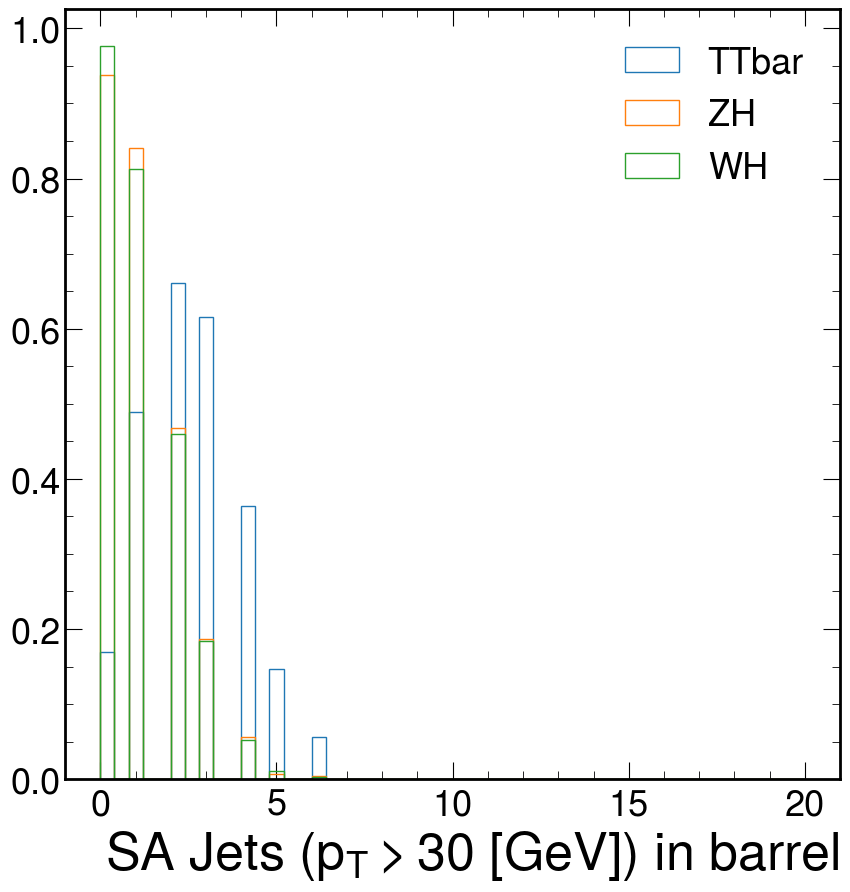

In [149]:
bins=50
plot_range = (0,20)
density = True
plt.hist(count_softactivity(ttbar_events), histtype='step',bins=bins,label='TTbar', density=density, range=plot_range)
#plt.hist(qcd_events.SoftActivityJetNjets10, histtype='step',bins=bins,label='QCD', density=density, range=plot_range)
plt.hist(count_softactivity(ZH_events), histtype='step',bins=bins,label='ZH', density=density, range=plot_range)
plt.hist(count_softactivity(WH_events), histtype='step',bins=bins,label='WH', density=density, range=plot_range)
plt.legend(frameon=False)
plt.xlabel(r'SA Jets ($p_T > 30$ [GeV]) in barrel')

Text(1, 0, 'Soft Activity Jets ($p_T > 10$ [GeV])')

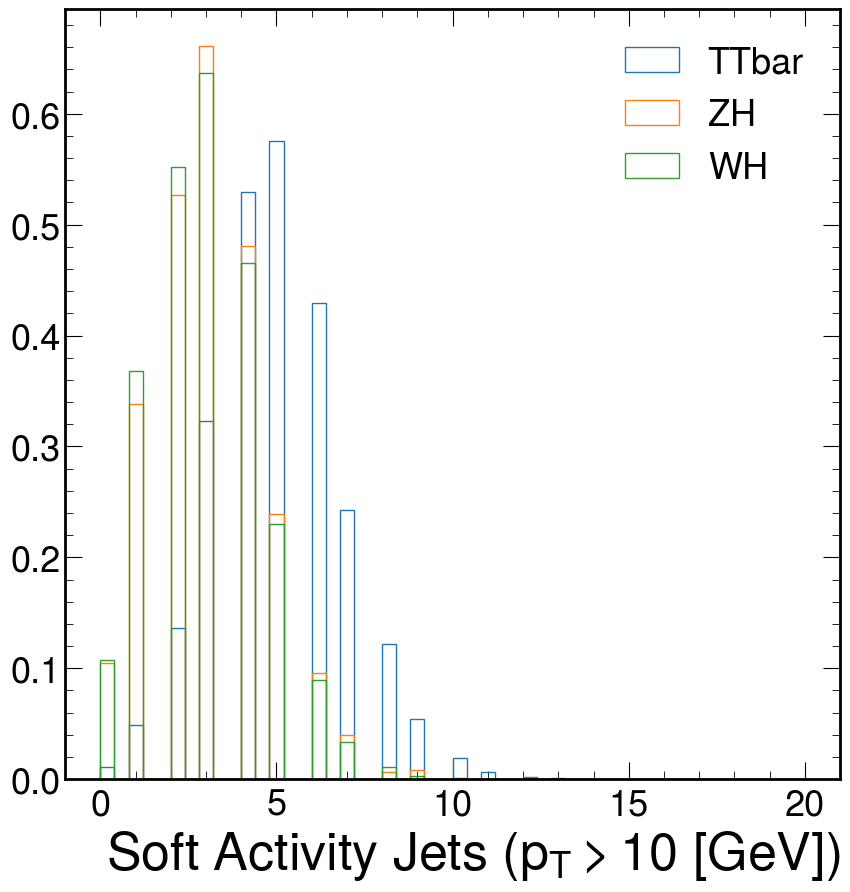

In [138]:
bins=50
plot_range = (0,20)
# density = True
plt.hist(ttbar_events.SoftActivityJetNjets10, histtype='step',bins=bins,label='TTbar', density=density, range=plot_range)
#plt.hist(qcd_events.SoftActivityJetNjets10, histtype='step',bins=bins,label='QCD', density=density, range=plot_range)
plt.hist(ZH_events.SoftActivityJetNjets10, histtype='step',bins=bins,label='ZH', density=density, range=plot_range)
plt.hist(WH_events.SoftActivityJetNjets10, histtype='step',bins=bins,label='WH', density=density, range=plot_range)
plt.legend(frameon=False)
plt.xlabel(r'Soft Activity Jets ($p_T > 10$ [GeV])')

In [10]:
njets_singlet = count_btag_ak4(singlet_events)
njets_ttbar = count_btag_ak4(ttbar_events)
njets_qcd = count_btag_ak4(qcd_events)
njets_ZH = count_btag_ak4(ZH_events)
njets_WH = count_btag_ak4(WH_events)

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(


Text(1, 0, 'b-tagged AK4 Jets (outside VH cands)')

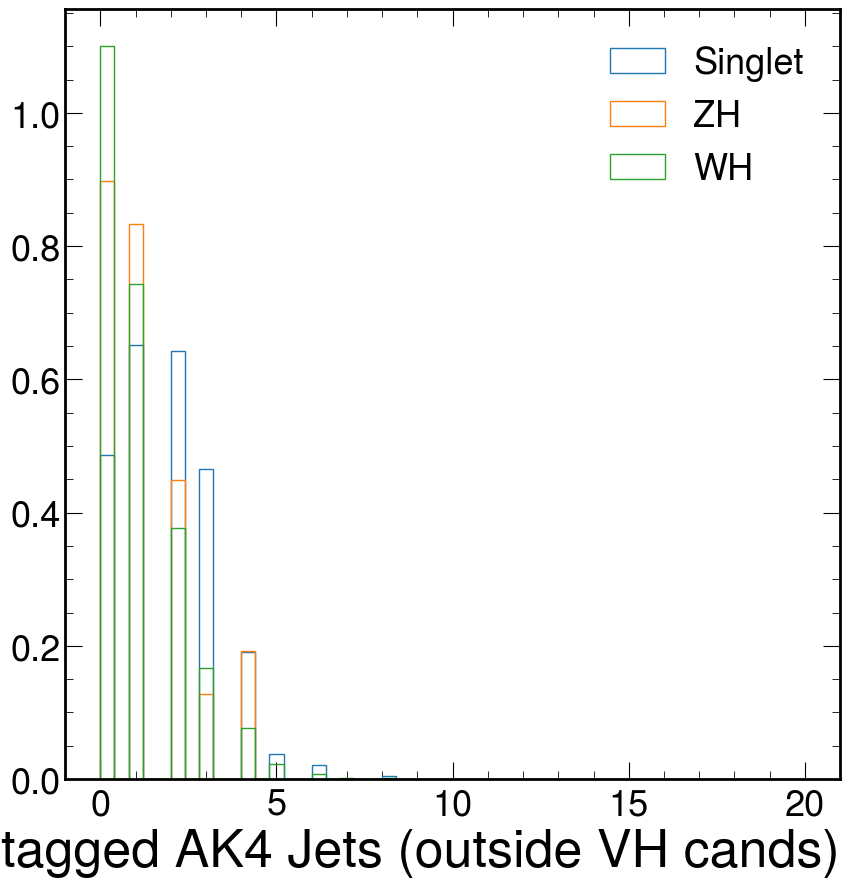

In [13]:
bins=50
plot_range = (0,20)
density = True
# plt.hist(njets_ttbar, histtype='step',bins=bins,label='TTbar', density=density, range=plot_range)
# plt.hist(njets_qcd, histtype='step',bins=bins,label='QCD', density=density, range=plot_range)
plt.hist(njets_singlet, histtype='step',bins=bins,label='Singlet', density=density, range=plot_range)
plt.hist(njets_ZH, histtype='step',bins=bins,label='ZH', density=density, range=plot_range)
plt.hist(njets_WH, histtype='step',bins=bins,label='WH', density=density, range=plot_range)
plt.legend(frameon=False)
plt.xlabel('b-tagged AK4 Jets (outside VH cands)')

Text(1, 0, 'b-tagged AK4 Jets (outside VH cands)')

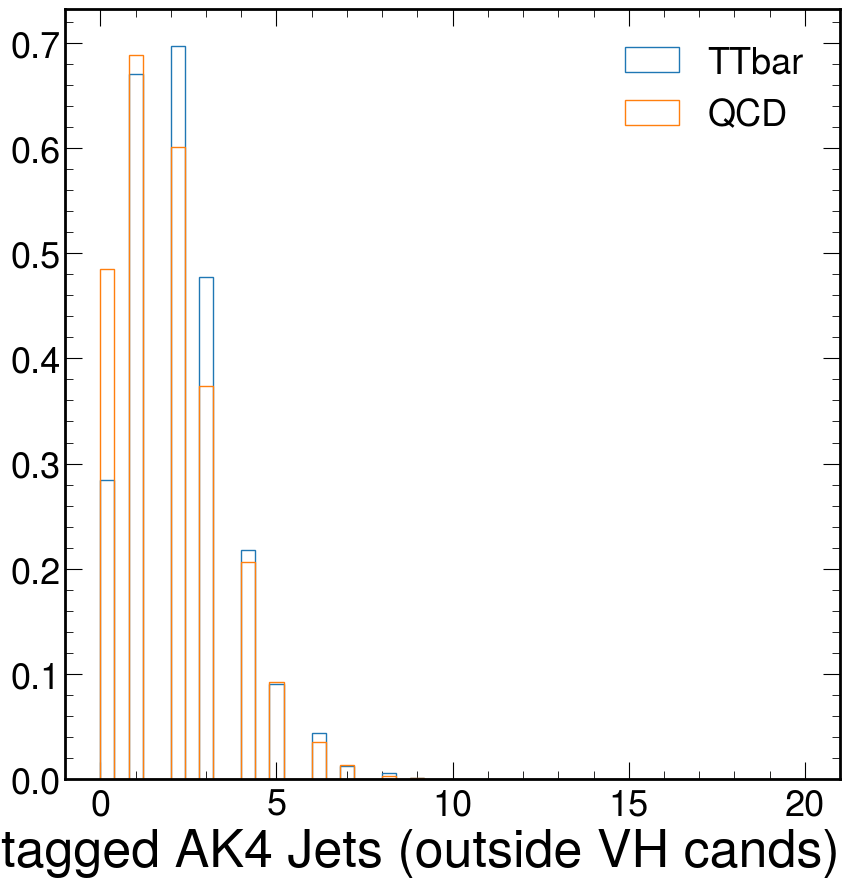

In [119]:
bins=50
plot_range = (0,20)
# density = True
plt.hist(njets_ttbar, histtype='step',bins=bins,label='TTbar', density=density, range=plot_range)
plt.hist(njets_qcd, histtype='step',bins=bins,label='QCD', density=density, range=plot_range)
# plt.hist(njets_ZH, histtype='step',bins=bins,label='ZH', density=density, range=plot_range)
# plt.hist(njets_WH, histtype='step',bins=bins,label='WH', density=density, range=plot_range)
plt.legend(frameon=False)
plt.xlabel('b-tagged AK4 Jets (outside VH cands)')

In [31]:
test[0]

<Array [53, 52.2, 42.6, 36.4, 32.5] type='5 * float32[parameters={"__doc__": "pt"}]'>

In [34]:
ak.count(test, axis=1)

<Array [5, 5, 3, 5, 7, 3, ... 4, 4, 8, 0, 6, 7] type='34712 * int64'>

In [13]:
ttbar_jet1, ttbar_jet2 = select_leading_jets(ttbar_events)
qcd_jet1, qcd_jet2 = select_leading_jets(qcd_events)
ZH_jet1, ZH_jet2 = select_leading_jets(ZH_events)
WH_jet1, WH_jet2 = select_leading_jets(WH_events)

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(


In [14]:
ttbar_tt2 = return_not_none(calculate_tt2(ttbar_jet2))
qcd_tt2 = return_not_none(calculate_tt2(qcd_jet2))
ZH_tt2 = return_not_none(calculate_tt2(ZH_jet2))
WH_tt2 = return_not_none(calculate_tt2(WH_jet2))

In [15]:
ttbar_tt1 = return_not_none(calculate_tt2(ttbar_jet1))
qcd_tt1 = return_not_none(calculate_tt2(qcd_jet1))
ZH_tt1 = return_not_none(calculate_tt2(ZH_jet1))
WH_tt1 = return_not_none(calculate_tt2(WH_jet1))

Text(1, 0, 'Particle Net W+Z Score')

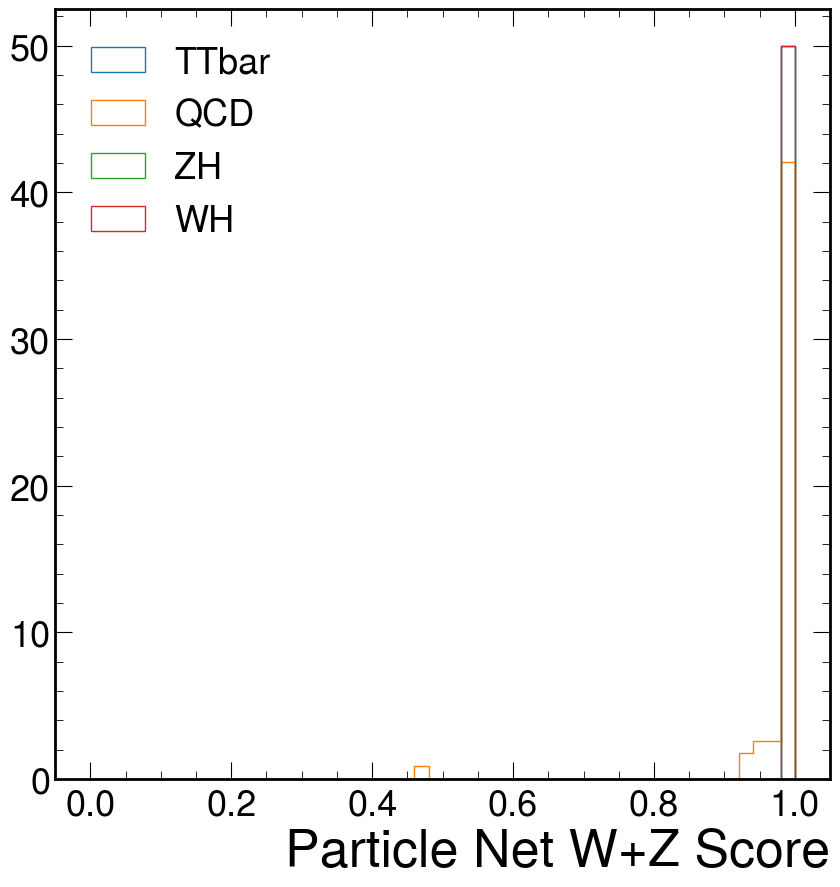

In [17]:
bins=50
plt.hist(ttbar_tt2, histtype='step',bins=bins,label='TTbar', density=True, range=(0,1))
plt.hist(qcd_tt2, histtype='step',bins=bins,label='QCD', density=True, range=(0,1))
plt.hist(ZH_tt2, histtype='step',bins=bins,label='ZH', density=True, range=(0,1))
plt.hist(WH_tt2, histtype='step',bins=bins,label='WH', density=True, range=(0,1))
plt.legend(frameon=False)
plt.xlabel('Particle Net W+Z Score')

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(1, 0, 'Particle Net W+Z Score')

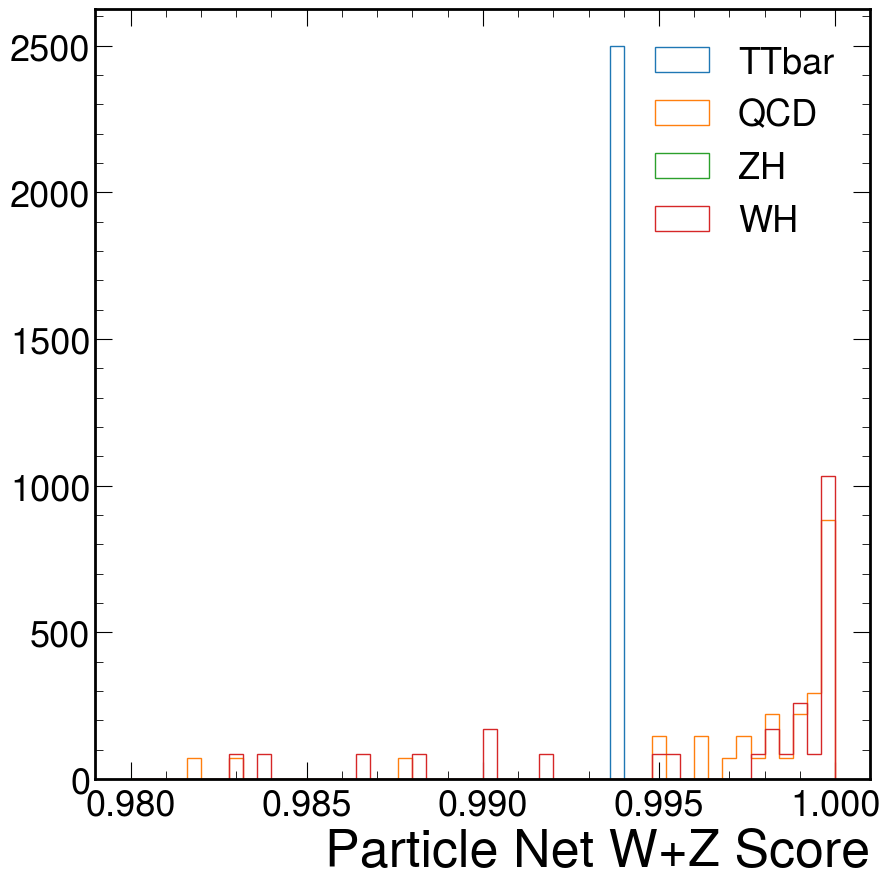

In [18]:
bins=50
plt.hist(ttbar_tt1, histtype='step',bins=bins,label='TTbar', density=True, range=(0.98,1))
plt.hist(qcd_tt1, histtype='step',bins=bins,label='QCD', density=True, range=(0.98,1))
plt.hist(ZH_tt1, histtype='step',bins=bins,label='ZH', density=True, range=(0.98,1))
plt.hist(WH_tt1, histtype='step',bins=bins,label='WH', density=True, range=(0.98,1))
plt.legend(frameon=False)
plt.xlabel('Particle Net W+Z Score')

Text(1, 0, 'Particle Net T vs QCD Score')

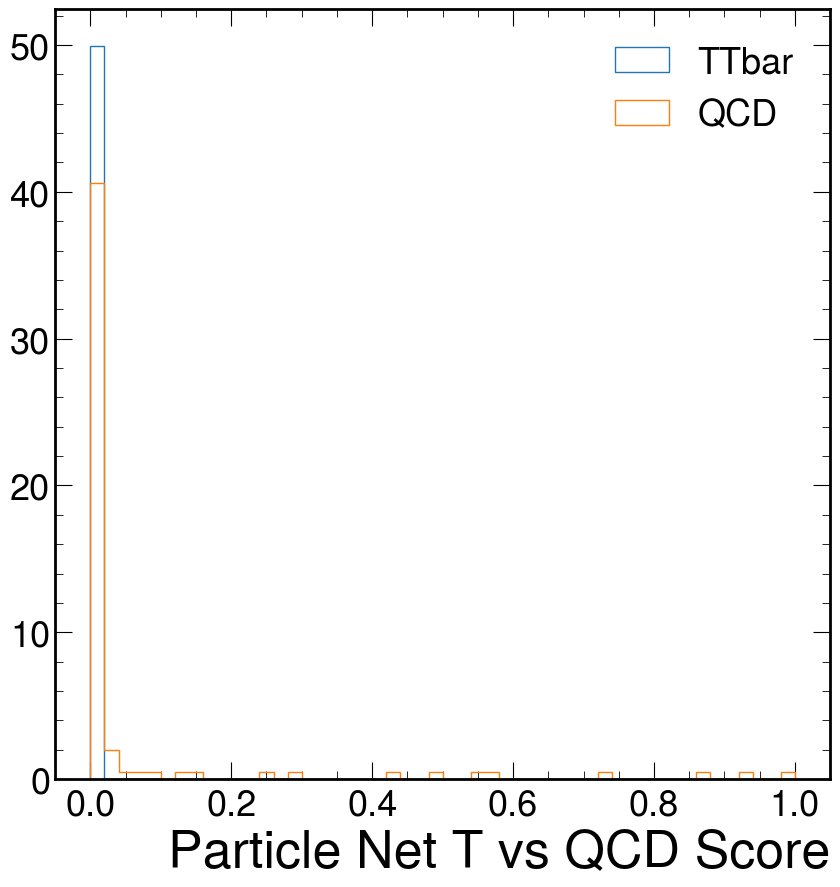

In [19]:
bins=50
range_plot = (0,1)
plt.hist(ttbar_jet1.particleNet_TvsQCD, histtype='step',bins=bins,label='TTbar', density=True, range=range_plot)
plt.hist(qcd_jet1.particleNet_TvsQCD, histtype='step',bins=bins,label='QCD', density=True, range=range_plot)
# plt.hist(ZH_jet2.particleNet_TvsQCD, histtype='step',bins=bins,label='ZH', density=True, range=range_plot)
# plt.hist(WH_jet2.particleNet_TvsQCD, histtype='step',bins=bins,label='WH', density=True, range=range_plot)
plt.legend(frameon=False)
plt.xlabel('Particle Net T vs QCD Score')

Text(1, 0, 'Deep Tag T vs QCD Score')

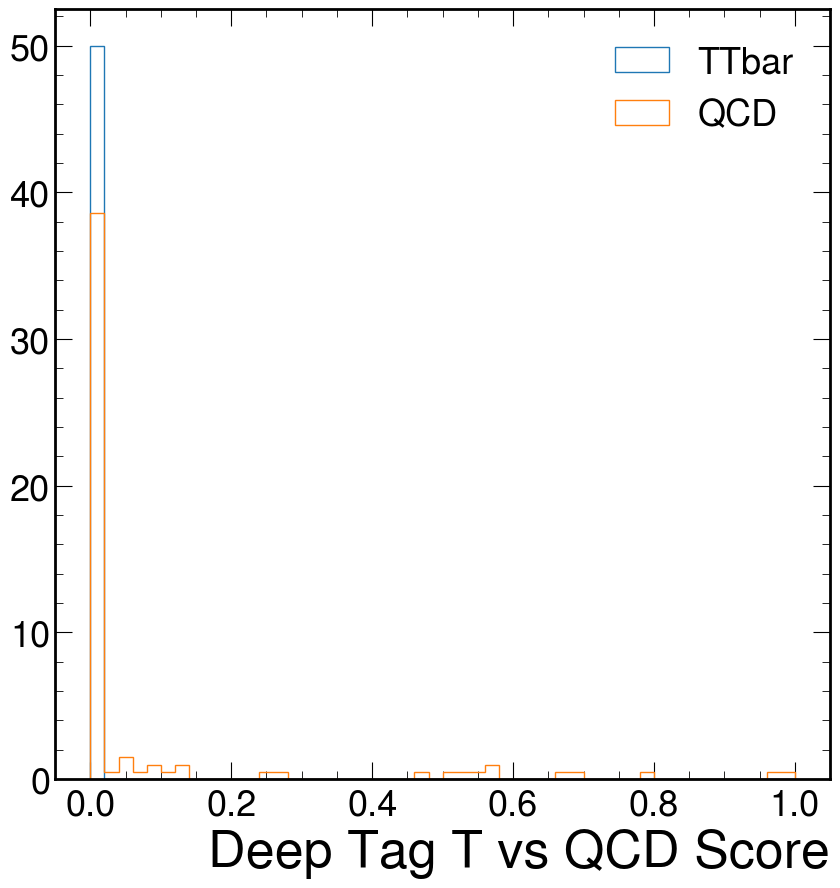

In [20]:
bins=50
range_plot = (0,1)
plt.hist(ttbar_jet1.deepTag_TvsQCD, histtype='step',bins=bins,label='TTbar', density=True, range=range_plot)
plt.hist(qcd_jet1.deepTag_TvsQCD, histtype='step',bins=bins,label='QCD', density=True, range=range_plot)
# plt.hist(ZH_jet2.deepTag_TvsQCD, histtype='step',bins=bins,label='ZH', density=True, range=range_plot)
# plt.hist(WH_jet2.deepTag_TvsQCD, histtype='step',bins=bins,label='WH', density=True, range=range_plot)
plt.legend(frameon=False)
plt.xlabel('Deep Tag T vs QCD Score')

Text(1, 0, 'tau3/2 Score')

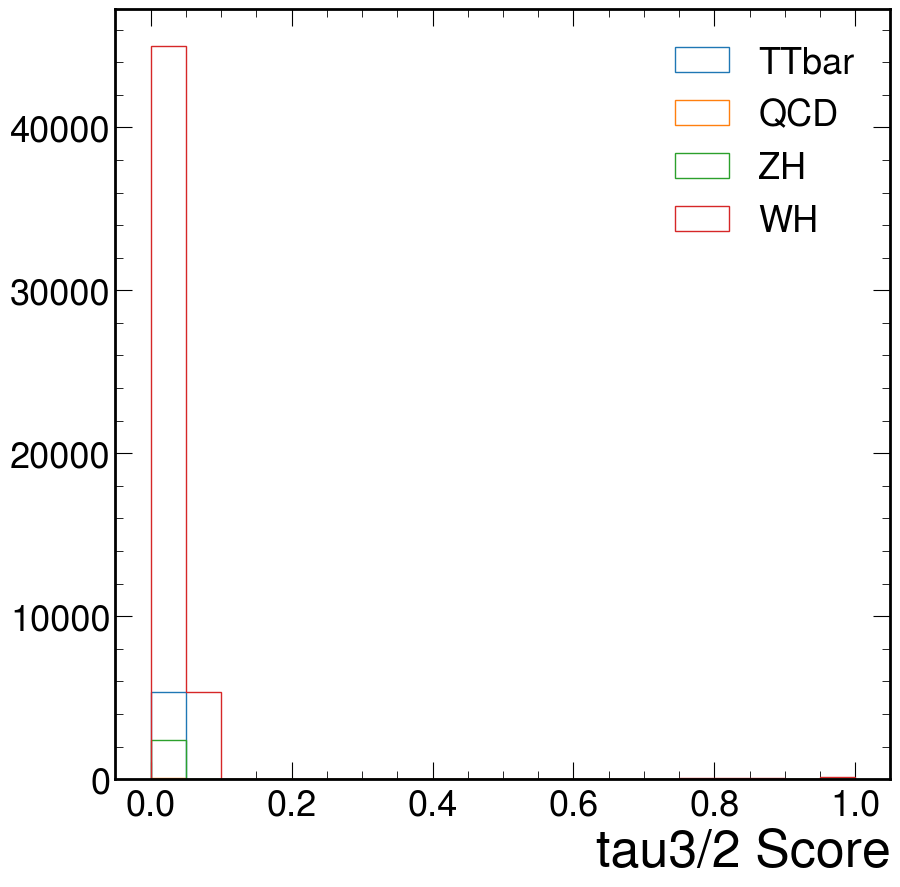

In [126]:
bins=20
range_plot = (0,1)
plt.hist(ttbar_jet2.tau3/ttbar_jet2.tau2, histtype='step',bins=bins,label='TTbar', density=False, range=range_plot)
plt.hist(qcd_jet2.tau3/qcd_jet2.tau2, histtype='step',bins=bins,label='QCD', density=False, range=range_plot)
plt.hist(ZH_jet2.tau3/ZH_jet2.tau2, histtype='step',bins=bins,label='ZH', density=False, range=range_plot)
plt.hist(WH_jet2.tau3/WH_jet2.tau2, histtype='step',bins=bins,label='WH', density=False, range=range_plot)
plt.legend(frameon=False)
plt.xlabel('tau3/2 Score')

Text(1, 0, 'Deep Tag T vs QCD Score')

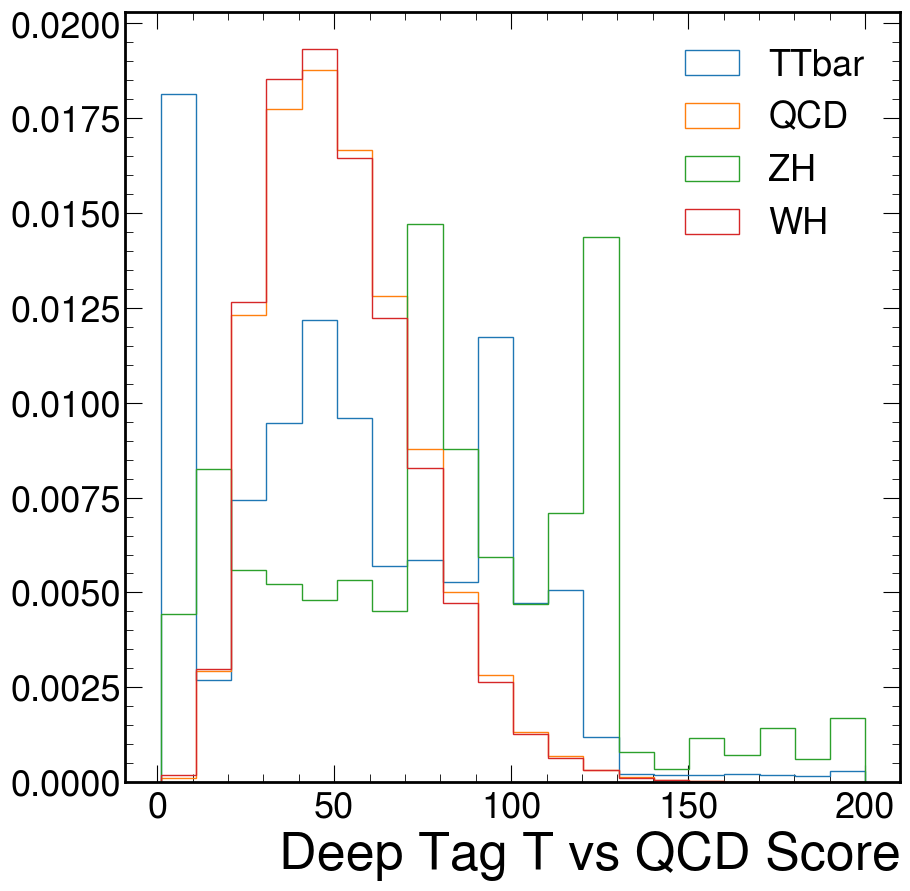

In [56]:
bins=20
range_plot = (1,200)
plt.hist(ttbar_jet2.nConstituents, histtype='step',bins=bins,label='TTbar', density=True, range=range_plot)
plt.hist(qcd_jet2.nConstituents, histtype='step',bins=bins,label='QCD', density=True, range=range_plot)
plt.hist(ZH_jet2.nConstituents, histtype='step',bins=bins,label='ZH', density=True, range=range_plot)
plt.hist(WH_jet2.nConstituents, histtype='step',bins=bins,label='WH', density=True, range=range_plot)
plt.legend(frameon=False)
plt.xlabel('Deep Tag T vs QCD Score')

In [6]:
fatjets = events.FatJet

candidatejet = fatjets[(fatjets.pt > 200)
                       & (abs(fatjets.eta) < 2.5)
                       & fatjets.isTight
                      ]

leadingjets = candidatejet[:, 0:2]
            

In [7]:
particleNetMD_Xbb = leadingjets.particleNetMD_Xbb
particleNetMD_Xcc = leadingjets.particleNetMD_Xcc
particleNetMD_Xqq = leadingjets.particleNetMD_Xqq
particleNetMD_QCD = leadingjets.particleNetMD_QCD

# ascending = true                                                                                                                                
indices = ak.argsort(particleNetMD_Xbb,axis=1)

# candidate jet is more b-like (lower CvB score)                                                                                                           
candidatejet = return_not_none(ak.firsts(leadingjets[indices[:, 1:2]]))
            
# second jet is more charm-like (larger CvB score)                                                                                                           
secondjet = return_not_none(ak.firsts(leadingjets[indices[:, 0:1]]))

In [8]:
ddcvb = leadingjets.btagDDCvBV2

# ascending = true                                                                                                                                
indices = ak.argsort(ddcvb,axis=1)

# candidate jet is more b-like (lower CvB score)                                                                                                           
candidatejet_old = ak.firsts(leadingjets[indices[:, 1:2]])
            
# second jet is more charm-like (larger CvB score)                                                                                                           
secondjet_old = ak.firsts(leadingjets[indices[:, 0:1]])

In [9]:
bins=np.linspace(0,1,11)

Text(1, 0, 'particleNetMD')

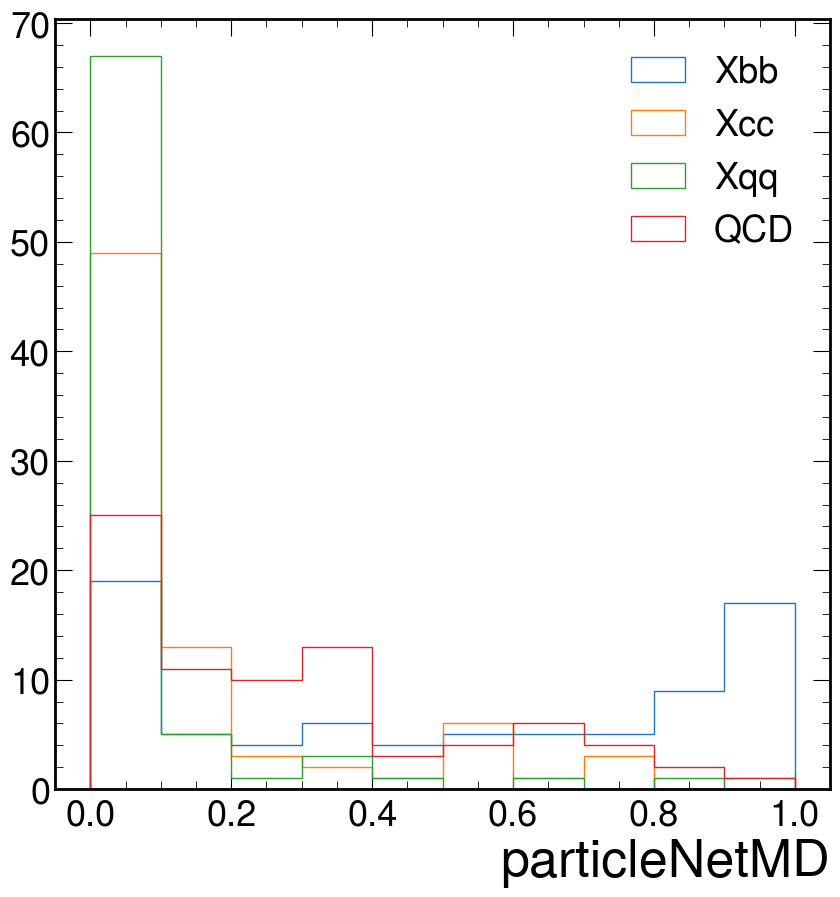

In [10]:
particleNetMD_Xbb = candidatejet.particleNetMD_Xbb
particleNetMD_Xcc = candidatejet.particleNetMD_Xcc
particleNetMD_Xqq = candidatejet.particleNetMD_Xqq
particleNetMD_QCD = candidatejet.particleNetMD_QCD

plt.hist(particleNetMD_Xbb,histtype='step',bins=bins,label='Xbb');
plt.hist(particleNetMD_Xcc,histtype='step',bins=bins,label='Xcc');
plt.hist(particleNetMD_Xqq,histtype='step',bins=bins,label='Xqq');
plt.hist(particleNetMD_QCD,histtype='step',bins=bins,label='QCD');
plt.legend(frameon=False)
plt.xlabel('particleNetMD')

Text(1, 0, 'Transformed particleNetMD')

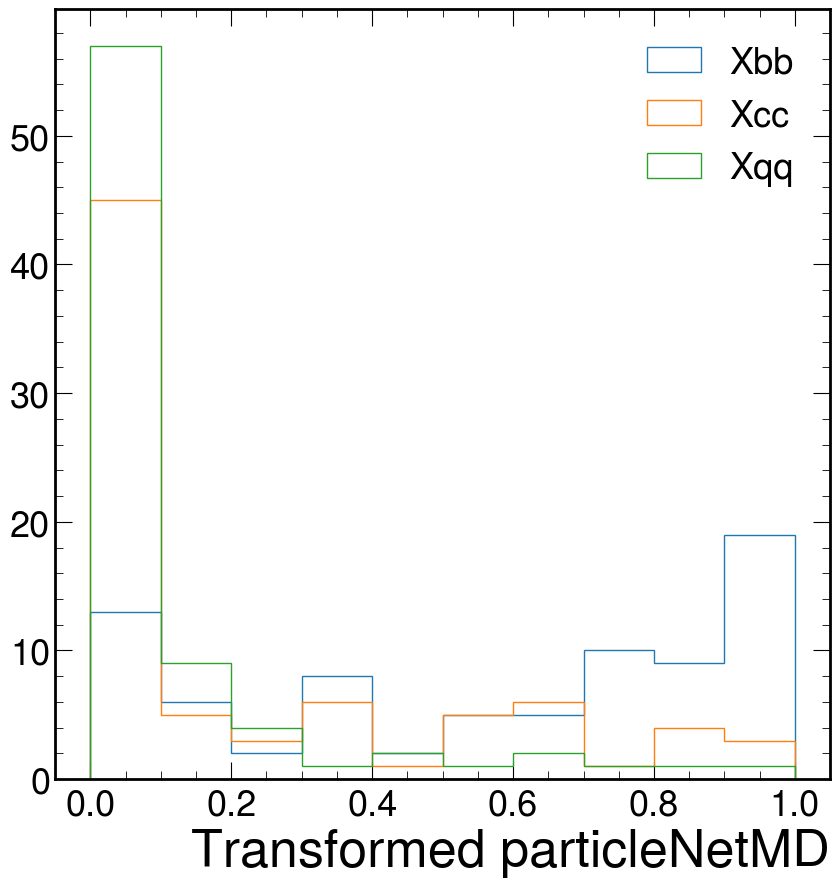

In [11]:
plt.hist(particleNetMD_Xbb / (1 - particleNetMD_Xcc - particleNetMD_Xqq),histtype='step',bins=bins,label='Xbb');
plt.hist(particleNetMD_Xcc / (1 - particleNetMD_Xbb - particleNetMD_Xqq),histtype='step',bins=bins,label='Xcc');
plt.hist(particleNetMD_Xqq / (1 - particleNetMD_Xbb - particleNetMD_Xcc),histtype='step',bins=bins,label='Xqq');
#plt.hist(particleNetMD_QCD / (particleNetMD_Xbb + particleNetMD_QCD + particleNetMD_Xcc + particleNetMD_Xqq),histtype='step',bins=bins,label='QCD');
plt.legend(frameon=False)
plt.xlabel('Transformed particleNetMD')

Text(1, 0, 'particleNet')

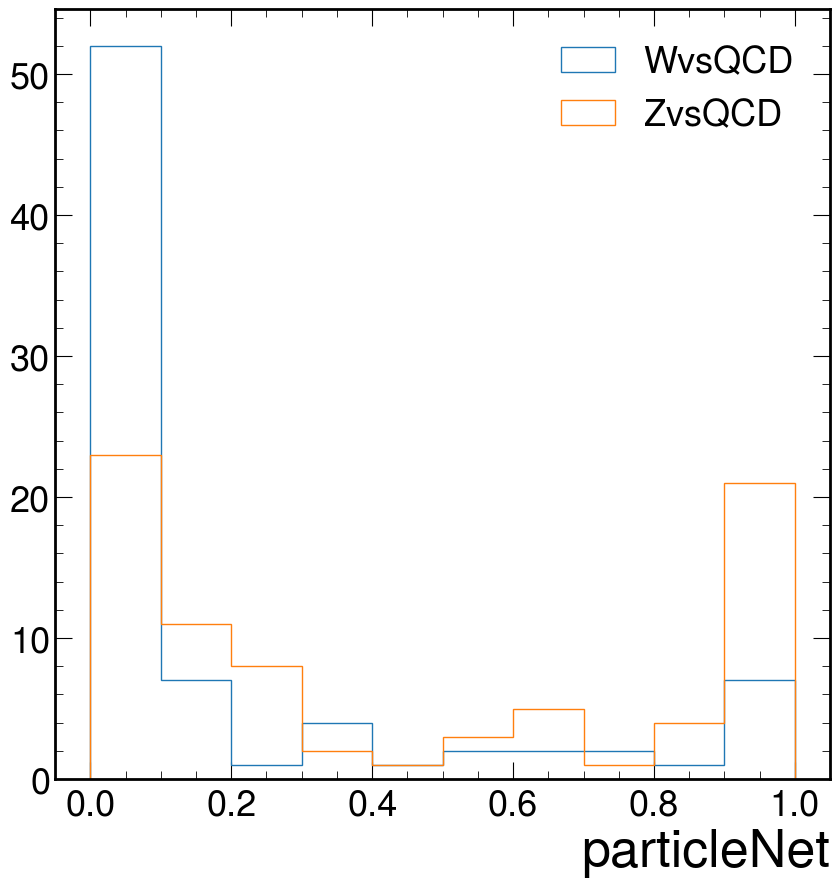

In [12]:
plt.hist(candidatejet.particleNet_WvsQCD,histtype='step',bins=bins,label='WvsQCD');
plt.hist(candidatejet.particleNet_ZvsQCD,histtype='step',bins=bins,label='ZvsQCD');
plt.legend(frameon=False)
plt.xlabel('particleNet')

Text(1, 0, 'particleNetMD')

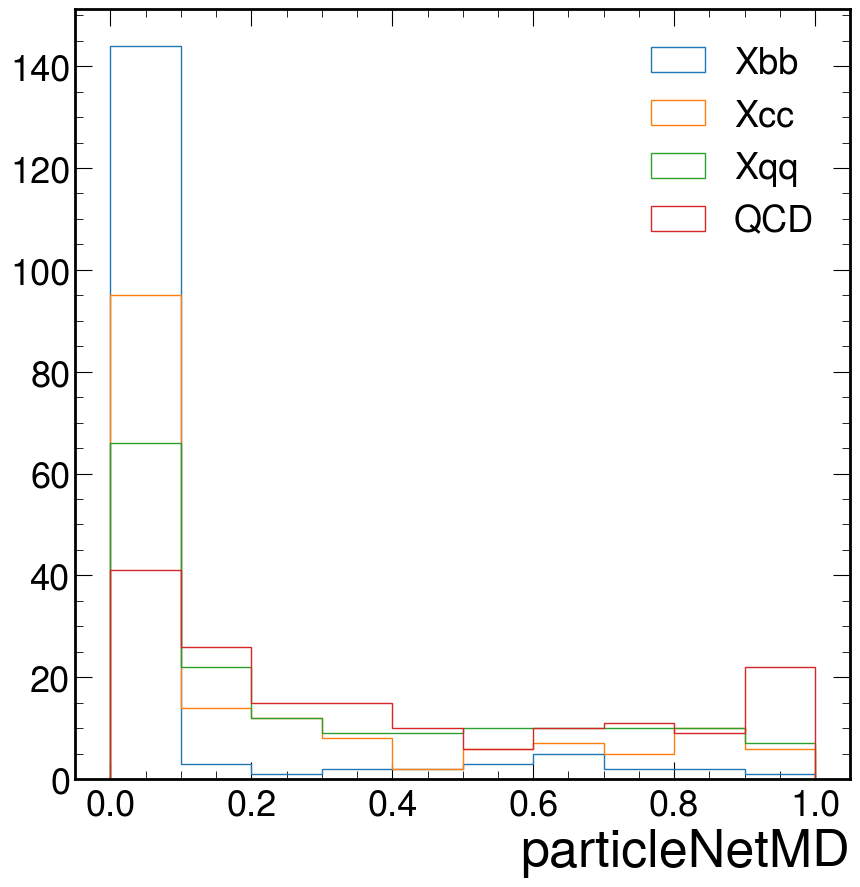

In [13]:
particleNetMD_Xbb = secondjet.particleNetMD_Xbb
particleNetMD_Xcc = secondjet.particleNetMD_Xcc
particleNetMD_Xqq = secondjet.particleNetMD_Xqq
particleNetMD_QCD = secondjet.particleNetMD_QCD

plt.hist(particleNetMD_Xbb,histtype='step',bins=bins,label='Xbb');
plt.hist(particleNetMD_Xcc,histtype='step',bins=bins,label='Xcc');
plt.hist(particleNetMD_Xqq,histtype='step',bins=bins,label='Xqq');
plt.hist(particleNetMD_QCD,histtype='step',bins=bins,label='QCD');
plt.legend(frameon=False)
plt.xlabel('particleNetMD')

165
165
165


Text(1, 0, 'Transformed particleNetMD')

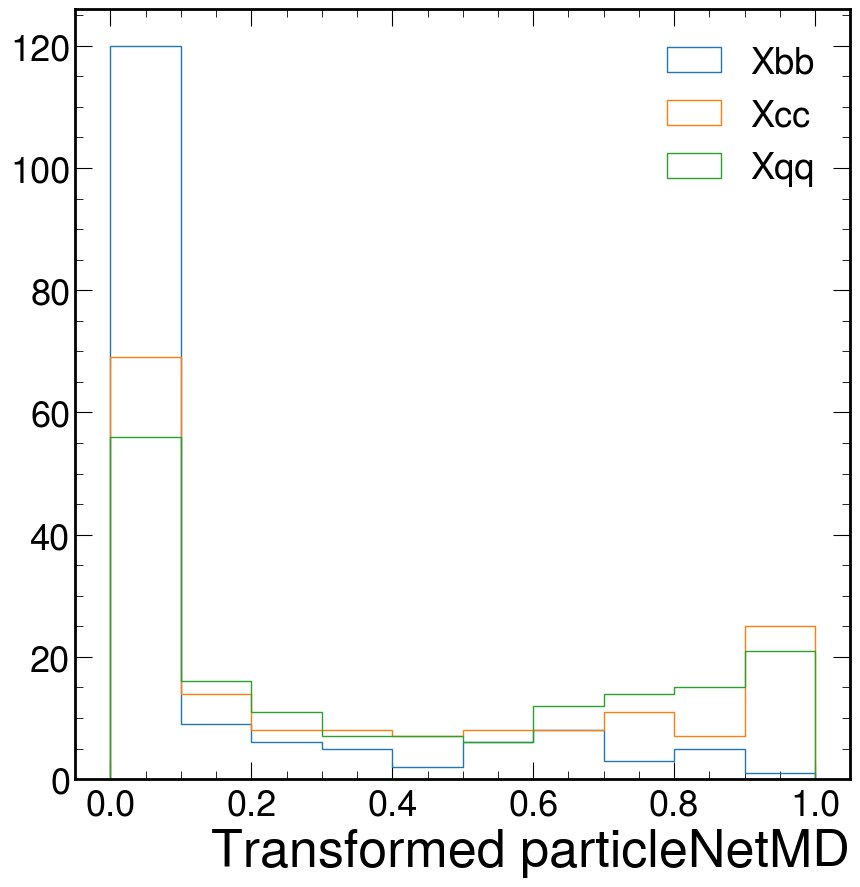

In [14]:
check_not_none(particleNetMD_Xbb / (1 - particleNetMD_Xcc - particleNetMD_Xqq))
check_not_none(particleNetMD_Xcc / (1 - particleNetMD_Xbb - particleNetMD_Xqq))
check_not_none(particleNetMD_Xqq / (1 - particleNetMD_Xbb - particleNetMD_Xcc))

plt.hist(particleNetMD_Xbb / (1 - particleNetMD_Xcc - particleNetMD_Xqq),histtype='step',bins=bins,label='Xbb');
plt.hist(particleNetMD_Xcc / (1 - particleNetMD_Xbb - particleNetMD_Xqq),histtype='step',bins=bins,label='Xcc');
plt.hist(particleNetMD_Xqq / (1 - particleNetMD_Xbb - particleNetMD_Xcc),histtype='step',bins=bins,label='Xqq');
#plt.hist(particleNetMD_QCD / (particleNetMD_Xbb + particleNetMD_QCD + particleNetMD_Xcc + particleNetMD_Xqq),histtype='step',bins=bins,label='QCD');
plt.legend(frameon=False)
plt.xlabel('Transformed particleNetMD')

Text(1, 0, 'particleNet')

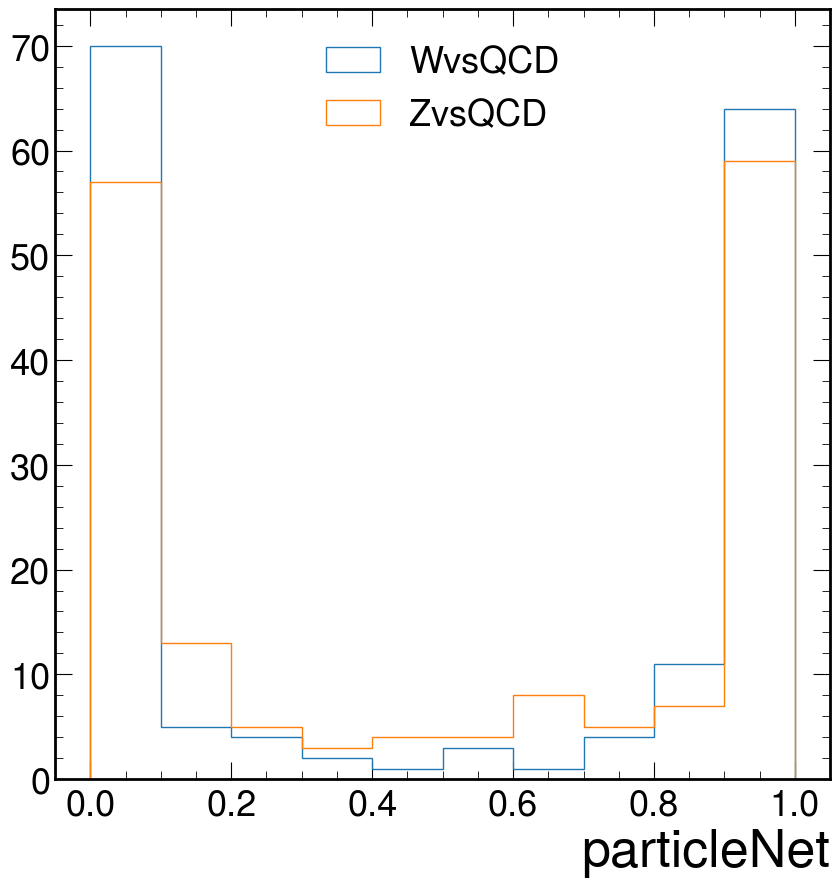

In [15]:
plt.hist(secondjet.particleNet_WvsQCD,histtype='step',bins=bins,label='WvsQCD');
plt.hist(secondjet.particleNet_ZvsQCD,histtype='step',bins=bins,label='ZvsQCD');
plt.legend(frameon=False)
plt.xlabel('particleNet')

(array([ 2.,  4., 11., 39., 17.,  3.,  2.,  0.,  0.,  1.]),
 array([-236.75      , -174.2250061 , -111.69999695,  -49.17499924,
          13.35000038,   75.875     ,  138.3999939 ,  200.92500305,
         263.45001221,  325.9750061 ,  388.5       ]),
 <BarContainer object of 10 artists>)

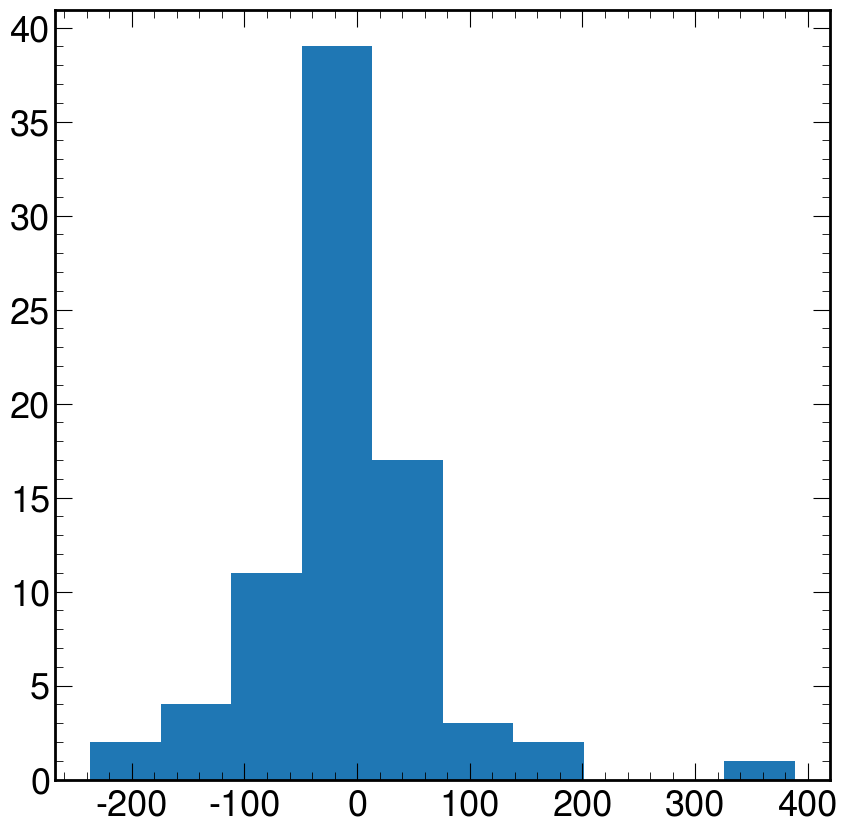

In [16]:
candidatejet_diff = return_not_none(candidatejet.pt) - return_not_none(candidatejet_old.pt)
plt.hist(candidatejet_diff)

(array([  1.,   0.,   0.,   2.,   3.,  17., 125.,  11.,   4.,   2.]),
 array([-388.5       , -325.9750061 , -263.45001221, -200.92500305,
        -138.3999939 ,  -75.875     ,  -13.35000038,   49.17499924,
         111.69999695,  174.2250061 ,  236.75      ]),
 <BarContainer object of 10 artists>)

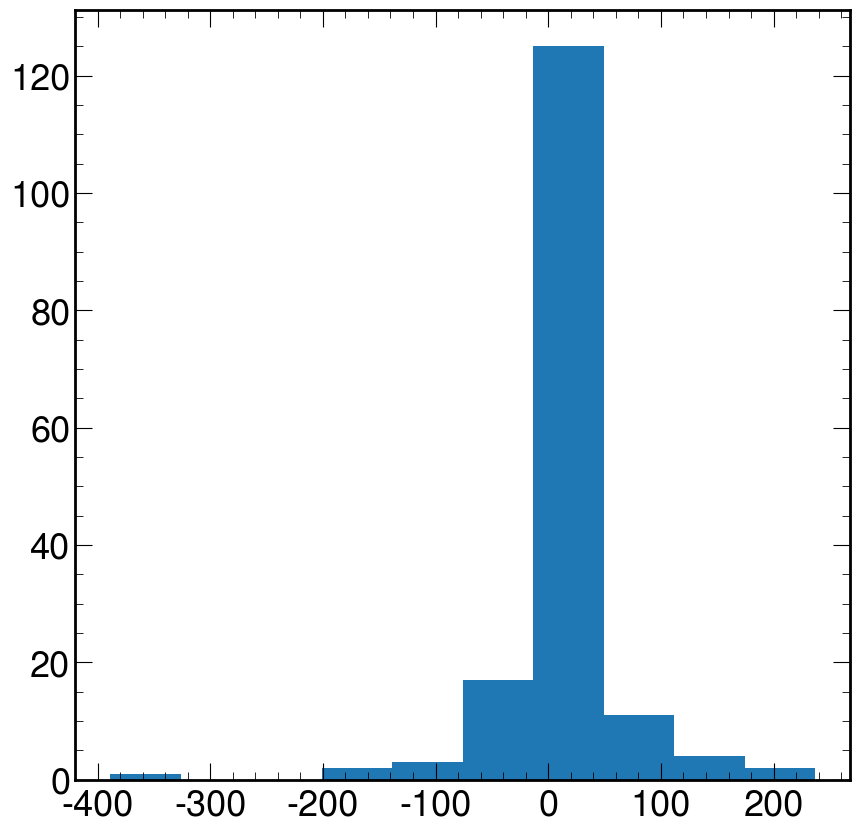

In [17]:
secondjet_diff = return_not_none(secondjet.pt) - return_not_none(secondjet_old.pt)
plt.hist(secondjet_diff)